# Задание 1

Необходимо с помощью SQL запроса собрать одну общую таблицу из всех данных витрин, которая должна включать в себя все поля этих витрин.

## Загрузка данных и импорты

In [1]:
import pandas as pd
import warnings
# мне через psycopg2 привычнее подключаться чем через алхимию. 
# Алхимия чаще для djangi + sqlite, а у мня в оснвном PostgeSQL
import matplotlib.pyplot as plt
import statsmodels.api as sm
import psycopg2 
import csv
import time
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
import pandas_profiling
from pandas_profiling import ProfileReport

Загрузка данных

In [2]:
%%time
excel_file = pd.ExcelFile('Витрины.xlsx')

CPU times: total: 7.08 s
Wall time: 7.1 s


In [3]:
sheet_names = excel_file.sheet_names

Загрузка листов

In [4]:
%%time
dfs = {}
for sheet_name in sheet_names:
    df = excel_file.parse(sheet_name)
    dfs[sheet_name] = df

CPU times: total: 48.8 s
Wall time: 48.9 s


Вывод списка названий листов

In [5]:
print(list(dfs.keys()))

['task', 'call', 'action', 'product', 'emp_x_org_gr', 'result', 'queue', 'group', 'mngmnt', 'horoscope']


Делаем отдельные датафреймы из каждой записи ключ/занчение словаря

In [6]:
for key, value in dfs.items():
    globals()[key] = value

Проверяем, что получилось

In [7]:
task.head(3)

,task_rk,task_stage_id,source_system_cd,create_dttm,finish_dttm
0,15431250,18.0,FW,2022-08-25 09:05:53,NaN
1,93508186,1.0,GI,2022-08-01 05:09:01,2022-08-02 13:35:02
2,357853,1.0,GI,2022-08-08 22:05:30,2022-08-08 22:07:32


In [8]:
call.head(3)

,wo_hit_rk,wo_task_rk,wo_queue_id,agent_login,wo_employee_rk,finish_dttm,duratoin_sec
0,73292106,93625442,12245,lyangama,66749466,2022-08-01 12:52:25,0.00
1,93763347,98572816,11696,enkoiion,88931008,2022-08-08 10:46:46,12.53
2,13988704,91292760,14354,kinalapo,61041016,2022-08-16 14:16:03,0.00


In [9]:
action.head(3)

,hit_rk,hit_status_result_id
0,3962005,2
1,71755300,5
2,38055819,5


In [10]:
product.head(3)

,hit_rk,hid,using_flg
0,41296509,4,NaN
1,22805443,4,NaN
2,47418895,4,NaN


In [11]:
emp_x_org_gr.head(3)

,employee_rk,org_group_rk
0,77291037,3240
1,70909770,2108
2,73448373,3237


In [12]:
result.head(3)

,hit_status_result_id,hit_status_result_desc
0,8,"Дозвон, Некорректное задание по звонку"
1,1,"Дозвон, Отказ"
2,6,"Дозвон, Отложить"


In [13]:
queue.head(3)

,queue_id,queue_desc
0,12049,Очередь 86
1,13677,Очередь 57
2,13041,Очередь 146


In [14]:
group.head(3)

,org_group_rk,org_management_rk,group_nm
0,2351,1636,Группа 1
1,2814,1780,Группа 2
2,2531,1720,Группа 3


In [15]:
mngmnt.head(3)

,org_management_rk,management_nm
0,401,Управление КЦ Дирис
1,307,Управление КЦ Черс
2,1834,Управление КЦ Помидор


In [16]:
horoscope.head(3)

,agent_login,horoscope
0,lyangama,Козерог
1,enkoiion,Козерог
2,kinalapo,Козерог


## Выгрузка / загрузка

Для создания требуемого запроса и его отработки будем пользоваться PostgeSQL. Поэтотому все полученные таблицы выгружаются в csv для последующего импорта в PostgeSQL. Можно, конечно на прямую загрузить датафреймы в таблицы, но не хочется возиться с типами данных.

In [17]:
task.to_csv('task.csv', index=False, sep='$', encoding='cp1251')
call.to_csv('call.csv', index=False, sep='$', encoding='cp1251')
action.to_csv('action.csv', index=False, sep='$', encoding='cp1251')
product.to_csv('product.csv', index=False, sep='$', encoding='cp1251')
emp_x_org_gr.to_csv('emp_x_org_gr.csv', index=False, sep='$', encoding='cp1251')
result.to_csv('result.csv', index=False, sep='$', encoding='cp1251')
queue.to_csv('queue.csv', index=False, sep='$', encoding='cp1251')
group.to_csv('group.csv', index=False, sep='$', encoding='cp1251')
mngmnt.to_csv('mngmnt.csv', index=False, sep='$', encoding='cp1251')
horoscope.to_csv('horoscope.csv', index=False, sep='$', encoding='cp1251')

## Создание таблиц

Подключение

In [18]:
# подключение
conn = psycopg2.connect("dbname=Allada user=postgres password=5498130")

Создание таблиц

In [19]:
cur = conn.cursor()
cur.execute('''
    DROP TABLE IF EXISTS task;
    CREATE TABLE task (
        task_rk VARCHAR,
        task_stage_id VARCHAR,
        source_system_cd VARCHAR,
        create_dttm VARCHAR,
        finish_dttm VARCHAR
    );

    DROP TABLE IF EXISTS call;
    CREATE TABLE call (
        wo_hit_rk VARCHAR,
        wo_task_rk VARCHAR,
        wo_queue_id VARCHAR,
        agent_login VARCHAR,
        wo_employee_rk VARCHAR,
        finish_dttm VARCHAR,
        duration_sec VARCHAR
    );

    DROP TABLE IF EXISTS action;
    CREATE TABLE action(
        hit_rk VARCHAR,
        hit_status_result_id VARCHAR
    );

    DROP TABLE IF EXISTS product;
    CREATE TABLE product (
        hit_rk VARCHAR,
        hid VARCHAR,
        using_flg VARCHAR
    );

    DROP TABLE IF EXISTS emp_x_org_gr;
    CREATE TABLE emp_x_org_gr (
        employee_rk VARCHAR,
        org_group_rk VARCHAR
    );

    DROP TABLE IF EXISTS result;
    CREATE TABLE result  (
        hit_status_result_id VARCHAR,
        hit_status_result_desc VARCHAR
    );

    DROP TABLE IF EXISTS queue;
    CREATE TABLE queue (
        queue_id VARCHAR,
        queue_desc VARCHAR
    );

    DROP TABLE IF EXISTS "group";
    CREATE TABLE "group" (
        org_group_rk VARCHAR,
        org_management_rk VARCHAR,
        group_nm VARCHAR
    );

    DROP TABLE IF EXISTS mngmnt;
    CREATE TABLE mngmnt (
        org_management_rk VARCHAR,
        management_nm VARCHAR
    );


    DROP TABLE IF EXISTS horoscope;
    CREATE TABLE horoscope (
        agent_login VARCHAR,
        horoscope VARCHAR
    );
''')
conn.commit()

<b>[Скрипт создания таблиц в sql](CREATE_TABLES.sql)</b>

Загрузка данных в таблицы

In [20]:
files = {
    'task': 'task.csv',
    'call': 'call.csv',
    'action': 'action.csv',
    'product': 'product.csv',
    'emp_x_org_gr': 'emp_x_org_gr.csv',
    'result': 'result.csv',
    'queue': 'queue.csv',
    'group': 'group.csv',
    'mngmnt': 'mngmnt.csv',
    'horoscope': 'horoscope.csv'
}

for table, file_path in files.items():
    with open(file_path, 'r') as f:
        next(f)  # Пропустить заголовок
        cur.copy_from(f, table, sep='$')    

# commit изменений и закрытие курсора
conn.commit()
cur.close()

Функция получения курсора. Потребуется при создании запроса.

In [21]:
# если вызвать с параметром 0 то придет список картежей
# если ничего не писать то датафрейм
def select(cunn, sql, df=1):
    cur = conn.cursor()  # получение курсора
    cur.execute(sql)
    res = cur.fetchall()
    if df == 1:
        columns = [desc[0] for desc in cur.description]
        res = pd.DataFrame(res, columns=columns)
    cur.close() # закрытие курсора
    conn.commit()
    return res

Проверяем работу функции

In [22]:
sql = '''select * from result limit 3'''

In [23]:
select(conn, sql)

,hit_status_result_id,hit_status_result_desc
0,8,"Дозвон, Некорректное задание по звонку"
1,1,"Дозвон, Отказ"
2,6,"Дозвон, Отложить"


## Запрос влючающий в себя все поля всех витрин

In [24]:
sql = '''
SELECT *
FROM call
LEFT JOIN task ON call.wo_task_rk = task.task_rk
LEFT JOIN action ON call.wo_hit_rk = action.hit_rk
LEFT JOIN product ON call.wo_hit_rk = product.hit_rk
LEFT JOIN emp_x_org_gr ON call.wo_employee_rk = emp_x_org_gr.employee_rk
LEFT JOIN result ON action.hit_status_result_id = result.hit_status_result_id
LEFT JOIN queue ON call.wo_queue_id = queue.queue_id
LEFT JOIN "group" AS g ON emp_x_org_gr.org_group_rk = g.org_group_rk
LEFT JOIN mngmnt ON g.org_management_rk = mngmnt.org_management_rk
LEFT JOIN horoscope ON call.agent_login = horoscope.agent_login
'''

<b>[Скрипт запроса sql](SELECT.sql)</b>

Запишем данные в датафрейм

In [25]:
big_df = select(conn, sql)

Закрываем соединение

In [26]:
conn.close()

In [27]:
big_df.head(3)

,wo_hit_rk,wo_task_rk,wo_queue_id,agent_login,wo_employee_rk,finish_dttm,duration_sec,task_rk,task_stage_id,source_system_cd,...,hit_status_result_desc,queue_id,queue_desc,org_group_rk,org_management_rk,group_nm,org_management_rk,management_nm,agent_login,horoscope
0,10001402,95516722,14642,alovmmma,44341014,2022-08-15 15:52:33,160.63,95516722,1.0,GI,...,"Дозвон, Перезвонить",14642,Очередь 50,378,415,Группа 41,415,Управление КЦ Парис,alovmmma,Водолей
1,10002397,5589411,4081,6446kmmi,95651109,2022-08-15 10:29:33,0.0,5589411,1.0,GI,...,Недозвон,4081,Очередь 78,3240,1621,Группа 36,1621,Управление КЦ Чизан,6446kmmi,Овен
2,10002617,98250515,14644,zovaiaoz,14809914,2022-08-15 16:19:44,0.0,98250515,1.0,GI,...,Недозвон,14644,Очередь 119,2531,1720,Группа 3,1720,Управление КЦ Кирис,zovaiaoz,Лев


## Подготовка датафрейма

Из получившегося датафрейма нужно удалить поля содержащие ключи. Они бесполезны для аналитеки. И заменить пропуски в поле `using_flg` нулями.

In [28]:
big_df.columns

Index(['wo_hit_rk', 'wo_task_rk', 'wo_queue_id', 'agent_login',
       'wo_employee_rk', 'finish_dttm', 'duration_sec', 'task_rk',
       'task_stage_id', 'source_system_cd', 'create_dttm', 'finish_dttm',
       'hit_rk', 'hit_status_result_id', 'hit_rk', 'hid', 'using_flg',
       'employee_rk', 'org_group_rk', 'hit_status_result_id',
       'hit_status_result_desc', 'queue_id', 'queue_desc', 'org_group_rk',
       'org_management_rk', 'group_nm', 'org_management_rk', 'management_nm',
       'agent_login', 'horoscope'],
      dtype='object')

Удаляем не нужные для аналитики столбцы

In [29]:
big_df = big_df.drop(['task_rk', 
                'task_stage_id',
                'wo_hit_rk',
                'wo_task_rk',
                'wo_queue_id',
                'wo_employee_rk',
                'hit_rk',
                'hit_status_result_id',
                'employee_rk', 
                'org_group_rk',
                'queue_id',
                'org_management_rk'], axis=1)

In [30]:
big_df.columns

Index(['agent_login', 'finish_dttm', 'duration_sec', 'source_system_cd',
       'create_dttm', 'finish_dttm', 'hid', 'using_flg',
       'hit_status_result_desc', 'queue_desc', 'group_nm', 'management_nm',
       'agent_login', 'horoscope'],
      dtype='object')

In [31]:
big_df.shape[1]

14

In [35]:
del df

In [33]:
%time
writer = pd.ExcelWriter('big_df.xlsx')
big_df.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

CPU times: total: 0 ns
Wall time: 0 ns


In [83]:
del task, call, action, product, emp_x_org_gr, result, queue, group, mngmnt, horoscope, big_df

In [36]:
%%time
df = pd.read_excel('big_df.xlsx')

CPU times: total: 1min 6s
Wall time: 1min 6s


Поле `using_flg` содержит пропуски. Нужно исправить ситуацию.

In [38]:
df['using_flg'].unique()

array([nan,  0.,  1.])

In [39]:
df['using_flg'].fillna(0, inplace=True)

In [40]:
df['using_flg'].unique()

array([0., 1.])

Исправляем типы данных содержащих вермя

In [41]:
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'], format='%Y-%m-%d %H:%M:%S')
df['create_dttm'] = pd.to_datetime(df['create_dttm'], format='%Y-%m-%d %H:%M:%S')

Записываем итоговый эксель

In [43]:
%time
writer = pd.ExcelWriter('df.xlsx')
df.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

CPU times: total: 0 ns
Wall time: 0 ns


# Задание 2

Необходимо посчитать следующие значения:
1.	Общее количество звонков со статусом «Дозвон, Успешно»
2.	Продажная конверсия. Ответ округлить до двух знаков после запятой.
   <br> a.	Продажная конверсия, % = Звонки со статусов «Дозвон, Успешно»/(Звонки со статусом «Дозвон, Успешно» + «Дозвон, Отказ)
3.	Средняя длительность одной коммуникации, закрытой статусом «Дозвон, Успешно». Ответ предоставить в секундах, округлить до двух знаков после запятой.


## Общее количество звонков со статусом «Дозвон, Успешно»

У агена `0212legr` есть анамальные значения длительности коммуникации.<br>
В ТЗ не уточнялось считать ли среднее с учетом анамалий или без. <br>
Посчитаю оба варианта

In [44]:
df['duration_sec'].max()

5874.71

Расчитываем колличество

In [46]:
total_sum = len(df[df['hit_status_result_desc'] == 'Дозвон, Успешно'])
print(f"Общее количество звонков со статусом 'Дозвон, Успешно' без учета анамальных значений: {total_sum}")

Общее количество звонков со статусом 'Дозвон, Успешно' без учета анамальных значений: 3310


In [47]:
total_sum_2 = len(df[(df['agent_login'] != '0212legr') & 
                            (df['hit_status_result_desc'] == 'Дозвон, Успешно')])
print("Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно», с учетом анамалий:", 
      round(total_sum_2, 2), "секунд")

Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно», с учетом анамалий: 3308 секунд


### Продажная конверсия

Расчет конверсии предпологается по формуле:
 $$ Конверсия = \frac{N_{Дозвон, Успешно}}{N_{Дозвон, Успешно} + N_{Дозвон, Отказ}}$$

Значения `0212legr`не влияют на итоговое округленное значение конверсии

In [48]:
call_fail = len(df[df['hit_status_result_desc'] == 'Дозвон, Отказ'])
print(f"Общее количество звонков со статусом 'Дозвон, Отказ': {call_fail}")

Общее количество звонков со статусом 'Дозвон, Отказ': 18459


<b>Итого:</b>

$$
N_{Дозвон, Успешно} = 3310
$$

$$
N_{Дозвон, Отказ} = 18459
$$

In [49]:
round(total_sum/(total_sum + call_fail), 2)

0.15

$$ 
Конверсия = 0,15
$$

## Средняя длительность одной коммуникации, закрытой статусом «Дозвон, Успешно»

In [50]:
mean_duration = df[df['hit_status_result_desc'] == 'Дозвон, Успешно']['duration_sec'].mean()
print("Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно»:", round(mean_duration, 2), "секунд")

Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно»: 110.18 секунд


In [51]:
mean_duration_2 = df[(df['agent_login'] != '0212legr') & 
                            (df['hit_status_result_desc'] == 'Дозвон, Успешно')]['duration_sec'].mean()
print("Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно», без учета значений 0212legr:", 
      round(mean_duration_2, 2), "секунд")

Средняя длительность коммуникации закрытой статусом «Дозвон, Успешно», без учета значений 0212legr: 107.71 секунд


## Анализ  базы данных 

Беглый анализ, что бы в общем понимать,что происходит.<br>
Делаем EDA еду)

Для этого сначала придется удалить анамалию 0212legr

In [54]:
df1 = df[(df['agent_login'] != '0212legr')]

In [58]:
x = len(df1[(df1['agent_login'] == '0212legr')])
print(x)

0


In [59]:
profile = ProfileReport(df1, title="df")

In [60]:
%%time
profile.to_file(output_file="df.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 15.9 s
Wall time: 15.7 s


In [61]:
profile.to_notebook_iframe()

**[Cылка на отчет EDA в html](df.html)** 

**[Cылка на отчет EDA в pdf](df.pdf)** 

<b>[Дашборды Power BI](xxx_08-04-2024_2.pbix)</b>

<b>[Дашборды Power BI в pdf](power_bi_08-04-2024_2.pdf)</b>

# Итоги

Проведен анализ данных колцентра содержащих информацию о звонках и работе операторов за август 2022 года. <br>
Аналитика данных не проводилась в разрезах кода систамы источника "source_system_cd" и очереди получения задания "queue_desc".<br>
 
Врезультате анализа выявлено (постронично):<br>

<b>Длительность</b>
* Поле `duration_sec` - длительность коммуникации в секундах соодержит аномалии. Они связаны с оператором `0212legr`. Средня длительность коммуникации этого оператора в разы превышает длительность остальных и составляет  `1971.56` сек. 
* Данные по коммуникации имеют явную сезонность. Сдесь в начале каждой недели происходит рост примерно до средины недели затем спад. Отдельно данные по сезонности приведены на диограме ниже. Фактически сезонность совпадает с диограммой длительности коммуникации распределенной по дням. *В power bi сезонность не делал, я не знаю где это в power bi делается:(*
* Сезонность данных по длительности коммуникации и количеству звонков явно имеют корреляцию с количеством задействованных операторов. Ближе к выходным их мало в начале недели много. 

<b>Результутивность</b>
* При звонках операторов наибольшее количество "недозвонов". Они составляют `56,6%`. Так же много звонков завершающихся отказами или просьбой перезвонить. Доля успешных звонков сотавляет `3,71%`. 
* Очень хороший результат достигнут при успешных звонках поператоров. 46.1% успешных звонков заканчиваются тем, что клиент начинает пользоваться продуктом.
* Распределение "утилизированных" клиентов по дням месяца во многом повторяет распределение звонков. Тут тоже корреляция к количеству звонков и в конечом счете к количеству задействованных операторов.

<b>Продукты</b>
* Самый предлогаемый продукт 4, его доля составляет `68,87%`. Продукт 2 - `19,95%`. На оставшиеся два продукта приходится `11,19%`.
* Предложения 3-го продукта возростают к концу месяца в товремя, как остальных уменьшаются.
* Предложения и начало пользования третьим продуктом примерно равны.
* По началу пользования 1 продукт является самым эффективным не смотря на то, что количество его предложений минимально. 
* Предложения продуктов 1 и 3 выглядят самыми продуктивными с точки зрения начала пользования (утилизации) клиентом.

<b>Группы и управления</b>

На первый взгляд, аномальным выглядит распределение агентов по группам. Здесь 36 группа содержит 314 агентов, что почти в трижды больше значения в 30 и 29 группах. В то же время 39 и 40 группы содержат вообще по одному человеку. <br>
Однако, вполне возможно, номера группам присваивались по мере их создания и тогда 39 и 40 группы - последние созданные и еще не успели заполниться.<br>
Так же, можно предположить, что группы распределены географически и их наполненность зависит от региона. Т.о. значения могут и не быть аномальными. *неплохо бы уточнить этот момент*.

<b>Эффективность групп и управлений.</b>

Количество операторов и суммарное значение флага пользования продуктом положительно коррелируют друг с другом. Начало пользования продуктом здесь является целевой метрикой.
Исходя из распределения этого целевого показателя между группами можно отметить, что так же важным фактором будет эффективность управления. Так группе 17 содержащей 82 оператора удалось добиться 112 достижений цели, в группе 2, на 46 операторов приходится 80 достижений, в группе 6 на 25 операторов приходится 61 достижение цели.
Если, группы нумеровались последовательно по мере создания, то можно предположить, что в группах с младшим числом наиболее опытный персонал. Однако, нет корреляции между уменьшением номера группы и эффективностью ее работы. Скорее всего дело именно в управлении или неких географических факторах.


Управление КЦ Чизан делает 24,15% от всего объема показателей начала пользования продуктом. В то же время — это управление является самым многочисленным.
В целом в некоторых управлениях, так же как и для группах присутствуют "аномальные" значения. Когда, количество участников управления значительно отличается от количества достижения целевой метрики (флаг начала пользования продуктом), но не понятно можно ли считать эти данные ошибочными. 
Разные сотрудники, показывают разную эффективность. Группы и управления зависят от сотрудников, операторов и управленцев. Так же на эффективность могут влиять разные не учтенные факторы. Для получения достоверных данных желательно уточнять случаи связанные с аномальными показателями групп и управлений. Сразу отсекать такие данные может быть ошибкой.

<b>Гороскоп</b><br>

Подавляющее большинство агентов девы. Агентов с знаком зодиака лев, меньше всего. <br>
Как следствие на долю дев приходиться больше всего достижений целевых метрик с различными статусами, но само по себе распределение аналогично другим знакам зодиака.<br>
Общее количество агентов со знаком зодиака дева в 6 раз больше чем у весов и в 2,4 больше чем у стрельцов. Соответственно и звонков они совершают больше в 5 раз и других достижений больше. 
Заметная корреляция межу знаком зодиака оператора и достижения целевых метрик отсутствует.

<b>Что еще:</b><br>

На основании этого датафрейма можно построить предсказательные системы используя следующие поля:

1. 'finish_dttm' - дата-время завершения коммуникации (временные ряды для прогнозирования длительности коммуникации или вероятности завершения коммуникации в определенное время)
2. 'duration_sec' - длительность коммуникации (предсказание длительности будущих коммуникаций)
3. 'hit_status_result_desc' - результат коммуникации (предсказание вероятности успешного завершения коммуникации или вероятности возникновения проблем)
4. `using_flg` - предсказание достижений по ключевой метрике.


Проведен анализ данных кол центра содержащих информацию о звонках и работе операторов за август 2022 года. <br>
Аналитика данных не проводилась в разрезах кода системы источника "source_system_cd" и очереди получения задания "queue_desc".<br>
 
В результате анализа выявлено (постранично):<br>

<b>Длительность</b>
* Поле `duration_sec` - длительность коммуникации в секундах содержит аномалии. Они связаны с оператором `0212legr`. Средняя длительность коммуникации этого оператора в разы превышает длительность остальных и составляет  `1971.56` сек. 
* Данные по коммуникации имеют явную сезонность. Здесь в начале каждой недели происходит рост примерно до средины недели затем спад. Отдельно данные по сезонности приведены на диаграмме ниже. Фактически сезонность совпадает с диаграммой длительности коммуникации распределенной по дням. 
* Сезонность данных по длительности коммуникации и количеству звонков явно имеют корреляцию с количеством задействованных операторов. Ближе к выходным их мало в начале недели много. 

<b>Результативность</b>
* При звонках операторов наибольшее количество "не дозвонов". Они составляют `56,6%`. Так же много звонков завершающихся отказами или просьбой перезвонить. Доля успешных звонков составляет `3,71%`. 
* Очень хороший результат достигнут при успешных звонках операторов. 46.1% успешных звонков заканчиваются тем, что клиент начинает пользоваться продуктом.
* Распределение "утилизированных" клиентов по дням месяца во многом повторяет распределение звонков. Тут тоже корреляция к количеству звонков и в конечном счете к количеству задействованных операторов.

<b>Продукты</b>
* Самый предлагаемый продукт 4, его доля составляет `68,87%`. Продукт 2 - `19,95%`. На оставшиеся два продукта приходится `11,19%`.
* Предложения 3-го продукта возрастают к концу месяца в то время, как остальных уменьшаются.
* Предложения и начало пользования третьим продуктом примерно равны.
* По началу пользования 1 продукт является самым эффективным, несмотря на то, что количество его предложений минимально. 
* Предложения продуктов 1 и 3 выглядят самыми продуктивными с точки зрения начала пользования (утилизации) клиентом.

<b>Группы и управления</b>

На первый взгляд, аномальным выглядит распределение агентов по группам. Здесь 36 группа содержит 314 агентов, что почти в трижды больше значения в 30 и 29 группах. В то же время 39 и 40 группы содержат вообще по одному человеку. <br>
Однако, вполне возможно, номера группам присваивались по мере их создания и тогда 39 и 40 группы - последние созданные и еще не успели заполниться.<br>
Так же, можно предположить, что группы распределены географически и их наполненность зависит от региона. Т.о. значения могут и не быть аномальными. *неплохо бы уточнить этот момент*.

<b>Эффективность групп и управлений.</b>

Количество операторов и суммарное значение флага пользования продуктом положительно коррелируют друг с другом. Начало пользования продуктом здесь является целевой метрикой.
Исходя из распределения этого целевого показателя между группами можно отметить, что так же важным фактором будет эффективность управления. Так группе 17 содержащей 82 оператора удалось добиться 112 достижений цели, в группе 2, на 46 операторов приходится 80 достижений, в группе 6 на 25 операторов приходится 61 достижение цели.
Если, группы нумеровались последовательно по мере создания, то можно предположить, что в группах с младшим числом наиболее опытный персонал. Однако, нет корреляции между уменьшением номера группы и эффективностью ее работы. Скорее всего дело именно в управлении или неких географических факторах.


Управление КЦ Чизан делает 24,15% от всего объема показателей начала пользования продуктом. В то же время — это управление является самым многочисленным.
В целом в некоторых управлениях, так же, как и для групп присутствуют "аномальные" значения. Когда, количество участников управления отрицательно коррелирует с достижением целевой метрики (флаг начала пользования продуктом), но не понятно можно ли считать эти данные ошибочными. 
Разные сотрудники, показывают разную эффективность. Группы и управления зависят от сотрудников, операторов и управленцев. Так же на эффективность могут влиять разные не учтенные факторы. Для получения достоверных данных желательно уточнять случаи, связанные с аномальными показателями групп и управлений. Сразу отсекать такие данные может быть ошибкой.

<b>Гороскоп</b><br>

Подавляющее большинство агентов девы. Агентов с знаком зодиака лев, меньше всего. <br>
Как следствие на долю дев приходиться больше всего достижений целевых метрик с различными статусами, но само по себе распределение аналогично другим знакам зодиака.<br>
Общее количество агентов со знаком зодиака дева в 6 раз больше чем у весов и в 2,4 больше чем у стрельцов. Соответственно и звонков они совершают больше в 5 раз и других достижений больше. 
Заметная корреляция межу знаком зодиака оператора и достижения целевых метрик отсутствует.

<b>Что еще:</b><br>

На основании этого датафрейма можно построить предсказательные системы используя следующие поля:

1. `finish_dttm` - дата-время завершения коммуникации (временные ряды для прогнозирования длительности коммуникации или вероятности завершения коммуникации в определенное время)
2. `duration_sec` - длительность коммуникации (предсказание длительности будущих коммуникаций)
3. `hit_status_result_desc` - результат коммуникации (предсказание вероятности успешного завершения коммуникации или вероятности возникновения проблем)
4. `using_flg` - предсказание достижений по ключевой метрике.

**Сезонность**

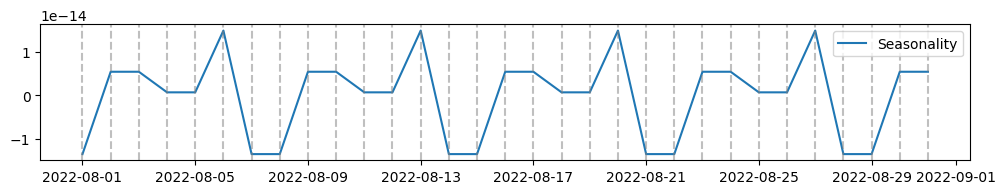

In [82]:
data = {
    'finish_dttm': pd.date_range(start='2022-01-01', periods=365, freq='D'),
    'duration_sec': range(365)
}
df = pd.DataFrame(data)

df.set_index('finish_dttm', inplace=True)

# Фильтрация данных для диапазона с 01.08.2022 по 31.08.2022
filtered_df = df['2022-08-01':'2022-08-31']

result = sm.tsa.seasonal_decompose(filtered_df['duration_sec'], model='additive')

# Построение графика с трендом и сезонностью, разбитым на каждый день
plt.figure(figsize=(12, 6))
plt.subplot(313)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='best')

for day in filtered_df.index:
    plt.axvline(x=day, color='gray', linestyle='--', alpha=0.5)

plt.show()
